# Analyse speleothem records

__Author:__ Kevin Fan, revised: MN Evans, Feng Zhu, Lucie Luecke
<br>__Last edited:__ 2025/12/17 by LL
<br>__Modified from code by:__ Lucie Luecke

This notebook reads the DoD2k, filters for late 20th century speleothem $\delta^{18}O$ records, and uses CRUTS4.07 gridded temperature and precipitated amount-weighted mean annual $\delta^{18}O$ of precipitation estimated by Bowen and Ravenaugh (2003, updated) to simulate o18 of speleothem calcite and compare results across a spatial gradient, to observations.

Note that to execute this notebook, you will need to first download and unzip source input data from Harris et al (2020) and Bowen and Ravenough (2003, updated) in the directory speleothem_modeling_inputs.  See the Bibliography cell at bottom of this notebook and the file Quickstart.md for URLs and more information.

- v1.3: cleaned up (MNE)
- v1.4: added nearest non-NaN search for CRUTS and d18Op data (FZ)
- v1.4d: General cleaning of code and comments up to cell 21 (LL)
- v1.5: move to lluecke for github push, clean up, move gcd and nearest2d functions to functions.py, revise for key elements and debug
- v1.6: brief cleanup, updated plots (LL, MNE, KF); tested with simpler dod2k-env and relative paths
- v1.7: implementing review suggestions (KF)
- v1.8: committed to statsmodels regression (KF)
- v2.0: tidied up and updated for dod2kv2.0 compatibility (LL)

## Set up working environment

Make sure the repo_root is added correctly, it should be: ```your_root_dir/dod2k```
This should be the working directory throughout this notebook (and all other notebooks).

In [1]:
#%load_ext autoreload
#%autoreload 2

import sys
import os
from pathlib import Path

# Add parent directory to path (works from any notebook in notebooks/)
# the repo_root should be the parent directory of the notebooks folder
init_dir = Path().resolve()
# Determine repo root
if init_dir.name == 'dod2k': repo_root = init_dir
elif init_dir.parent.name == 'dod2k': repo_root = init_dir.parent
else: raise Exception('Please review the repo root structure (see first cell).')

# Update cwd and path only if needed
if os.getcwd() != str(repo_root):
    os.chdir(repo_root)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

print(f"Repo root: {repo_root}")
if str(os.getcwd())==str(repo_root):
    print(f"Working directory matches repo root. ")

Repo root: C:\Users\aegir\Documents\PaleoCoLab\dod2k
Working directory matches repo root. 


In [2]:
# Import packages
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
from tqdm import tqdm
import psm
import statsmodels.api as sm
import scipy

from dod2k_utilities import ut_functions as utf # contains utility functions
from dod2k_utilities import ut_plot as uplt # contains plotting functions
from dod2k_utilities import ut_analysis as uta # contains plotting functions

## Read dataframe

Read compact dataframe.

{db_name} refers to the database, including 

    - dod2k_v2.0
    
All compact dataframes are saved in {repo_root}/data/{db_name} as {db_name}_compact.csv.

In [3]:
# read dataframe, choose from the list below, or specify your own

db_name = 'dod2k_v2.0'

# load dataframe
orig_df = utf.load_compact_dataframe_from_csv(db_name)
print(orig_df.info())
orig_df.name = db_name


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4781 entries, 0 to 4780
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   archiveType                    4781 non-null   object 
 1   dataSetName                    4781 non-null   object 
 2   datasetId                      4781 non-null   object 
 3   duplicateDetails               4781 non-null   object 
 4   geo_meanElev                   4699 non-null   float32
 5   geo_meanLat                    4781 non-null   float32
 6   geo_meanLon                    4781 non-null   float32
 7   geo_siteName                   4781 non-null   object 
 8   interpretation_direction       4781 non-null   object 
 9   interpretation_seasonality     4781 non-null   object 
 10  interpretation_variable        4781 non-null   object 
 11  interpretation_variableDetail  4781 non-null   object 
 12  originalDataURL                4781 non-null   o

## Filter dataframe for speleothem type records

In [4]:
# Filter for desired data, in this case, speleothem calcite oxygen isotope measurements from the years min_year to max_year
filtered_df = orig_df.loc[(orig_df["paleoData_proxy"] =="d18O") & (orig_df["archiveType"] == "Speleothem") & (orig_df["paleoData_notes"] == "calcite")]

# Filter data for time series that include records from or past the year 1960 AD
min_year = 1960 # Inclusive
max_year = 2006 # Exclusive

# d18O data ranges from 1960 to 2005- pick data to match the same timeframe
filtered_df = filtered_df.loc[orig_df["year"].apply(lambda x: np.max(x) >= min_year and np.min(x) < max_year)] #exclude post 2005 data
filtered_df.reset_index(inplace = True)

# Filter the filtered records for data in the correct timeframe
new_year = []
new_values = []
# For every row, apply above time conditions
for i in range (0, len(filtered_df)):
    index = np.where(filtered_df.iloc[i]["year"] >= min_year)
    new_year.append(filtered_df.iloc[i]["year"][index]) # Adds values to lists
    new_values.append(filtered_df.iloc[i]["paleoData_values"][index])
filtered_df["year"] = new_year # Create a dataframe with the filtered data lists populating it
filtered_df["paleoData_values"] = new_values
filtered_df.info()

filtered_df.name = 'dod2k_v2.0_speleothemcalciteoxygen'

print(filtered_df.name)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          61 non-null     int64  
 1   archiveType                    61 non-null     object 
 2   dataSetName                    61 non-null     object 
 3   datasetId                      61 non-null     object 
 4   duplicateDetails               61 non-null     object 
 5   geo_meanElev                   61 non-null     float32
 6   geo_meanLat                    61 non-null     float32
 7   geo_meanLon                    61 non-null     float32
 8   geo_siteName                   61 non-null     object 
 9   interpretation_direction       61 non-null     object 
 10  interpretation_seasonality     61 non-null     object 
 11  interpretation_variable        61 non-null     object 
 12  interpretation_variableDetail  61 non-null     objec

In [5]:
#%% check data extraction for proxy_type and archive_type
proxy_types   = filtered_df['paleoData_proxy'].unique()
archive_types = filtered_df['archiveType'].unique()
calcite_types = filtered_df['paleoData_notes'].unique()

print('Proxy type: ', proxy_types)
print('Archive type: ', archive_types)
print('Carbonate type: ', calcite_types)
# should give only ['d18O'], ['speleothem'], ['calcite']

Proxy type:  ['d18O']
Archive type:  ['Speleothem']
Carbonate type:  ['calcite']


### Plot data

saved figure in C:\Users\aegir\Documents\PaleoCoLab\dod2k/figs/dod2k_v2.0_speleothemcalciteoxygen/geo_dod2k_v2.0_speleothemcalciteoxygen.pdf


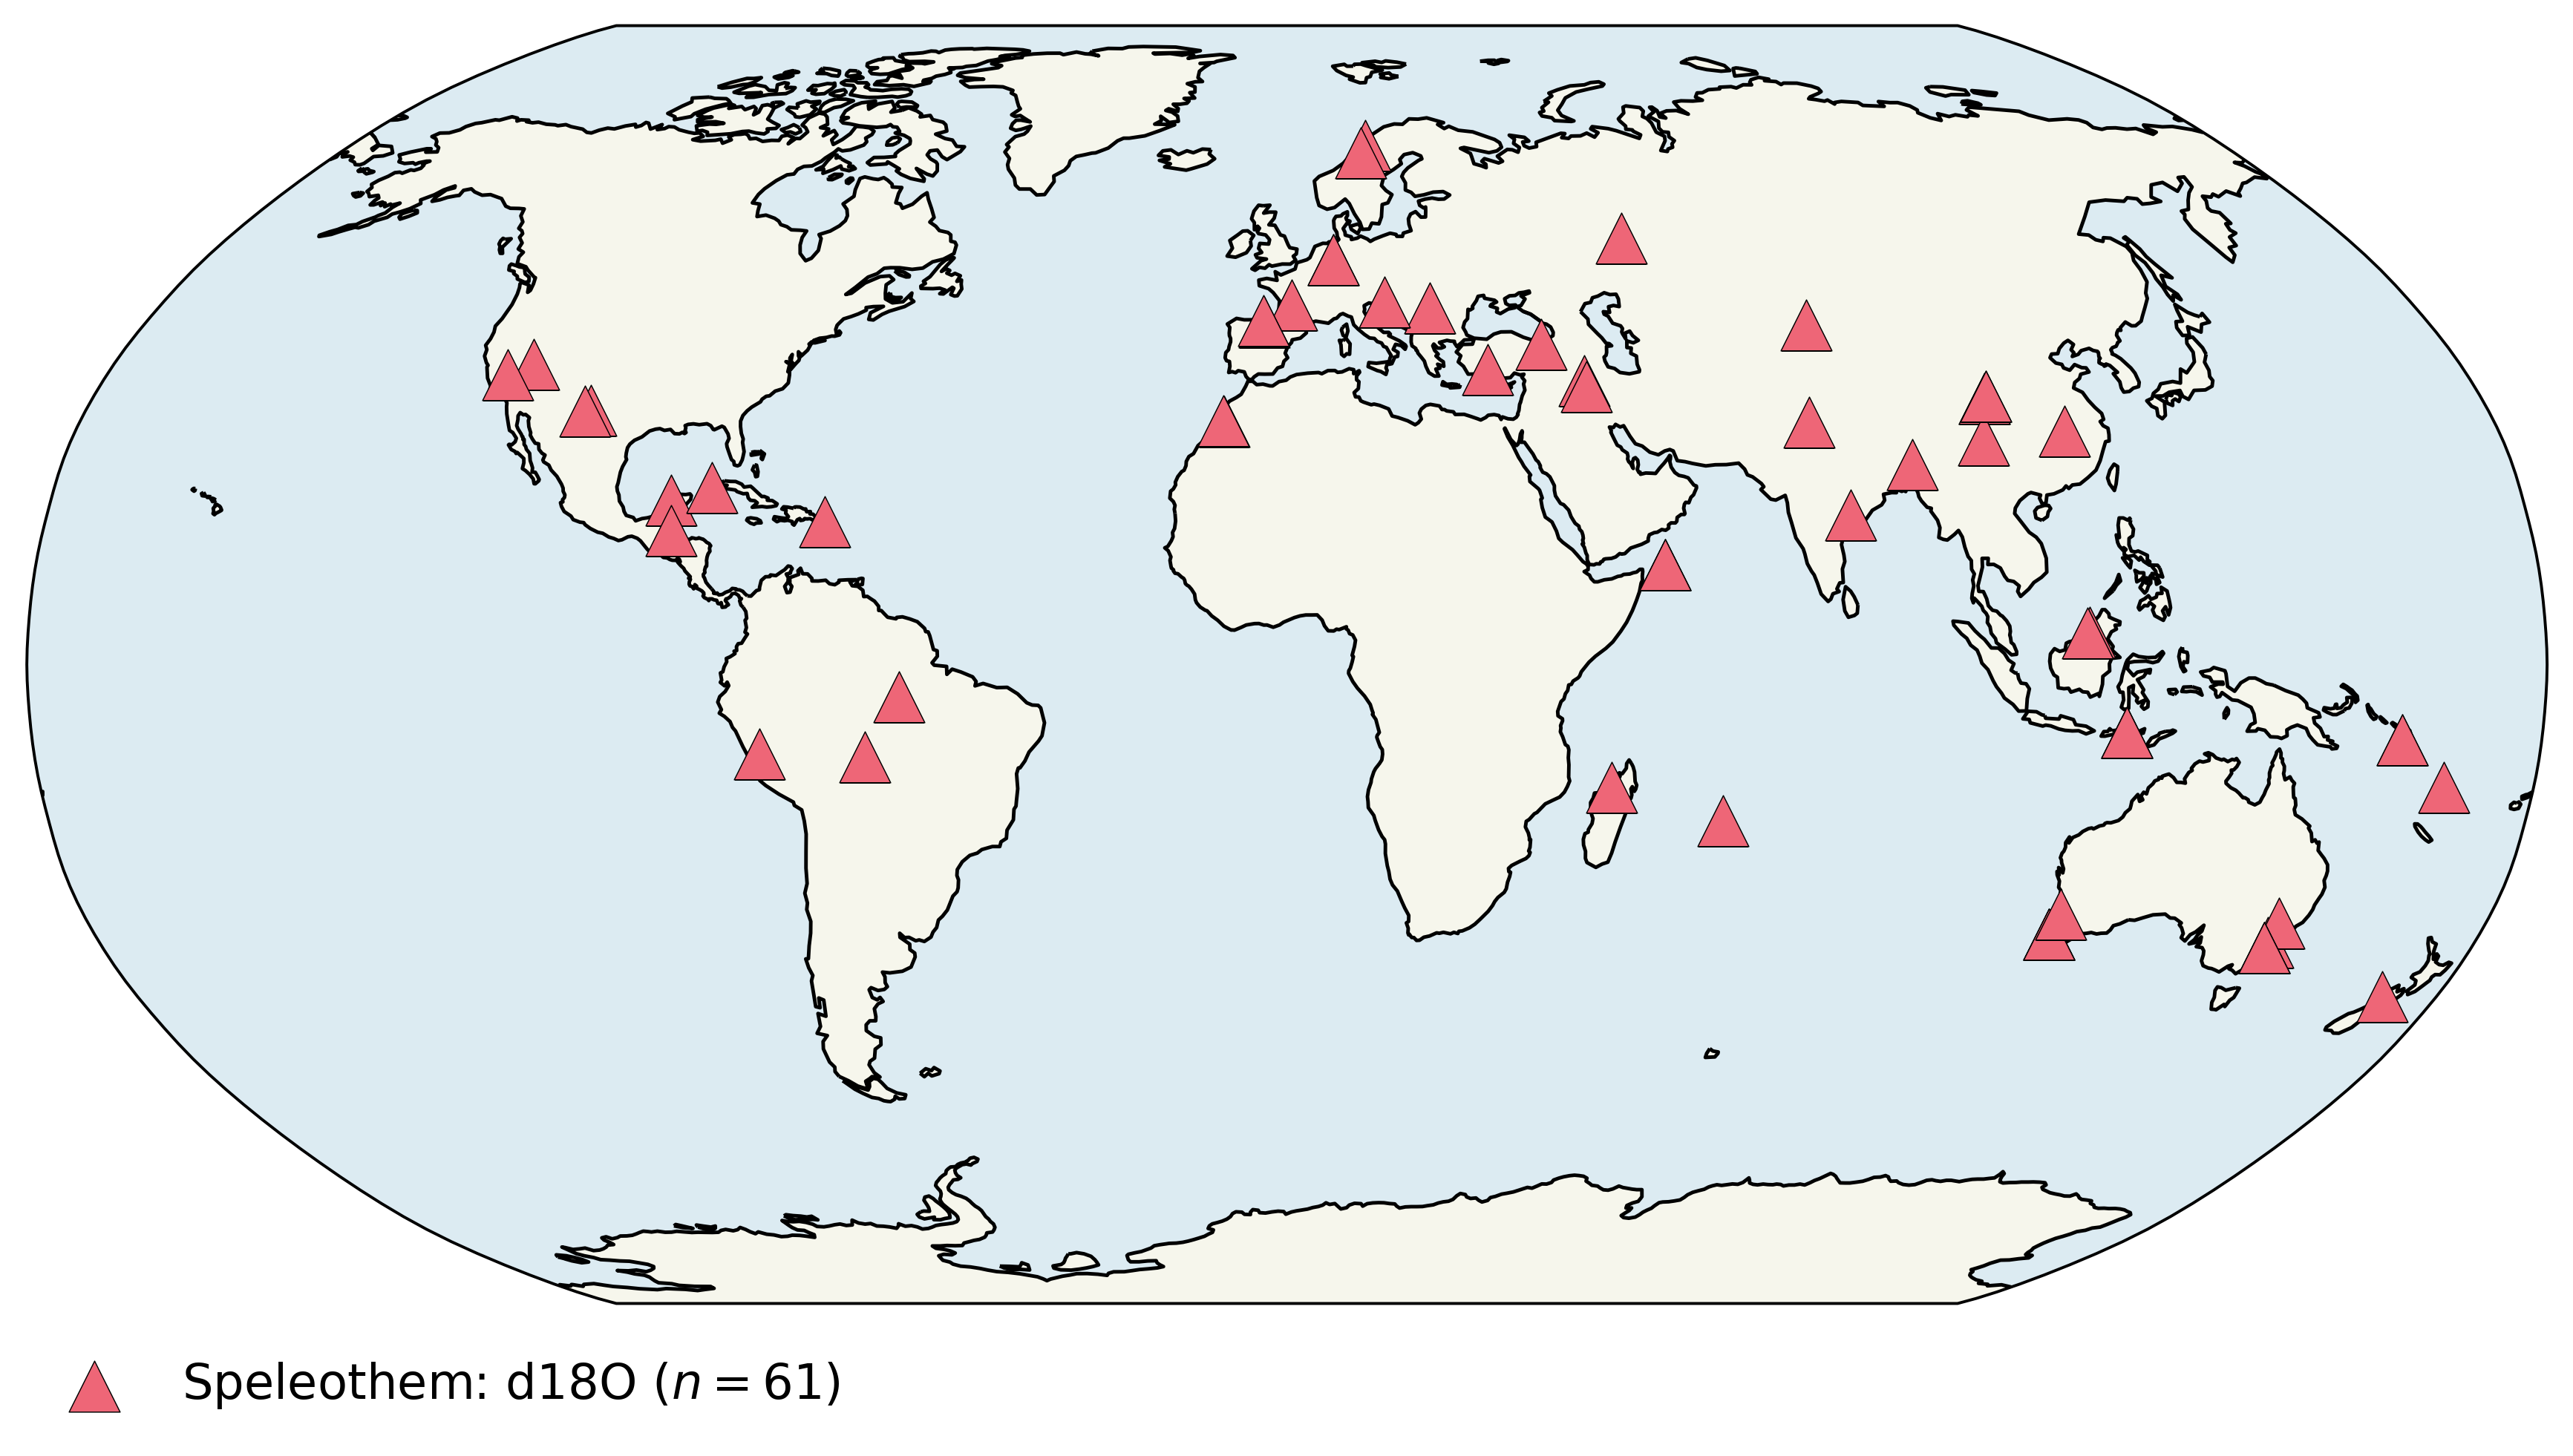

In [6]:
# count archive types
archive_count = {}
for ii, at in enumerate(set(filtered_df['archiveType'])):
    archive_count[at] = filtered_df.loc[filtered_df['archiveType']==at, 'archiveType'].count()

sort = np.argsort([cc for cc in archive_count.values()])
archives_sorted = np.array([cc for cc in archive_count.keys()])[sort][::-1]

fig = uplt.plot_geo_archive_proxy(filtered_df, {'Speleothem':'#EE6677'}, marker='^', figsize=(13/1.3, 8/1.3))
utf.save_fig(fig, f'geo_{filtered_df.name}', dir=filtered_df.name)

saved figure in C:\Users\aegir\Documents\PaleoCoLab\dod2k/figs/dod2k_v2.0_speleothemcalciteoxygen/time_dod2k_v2.0_speleothemcalciteoxygen.pdf


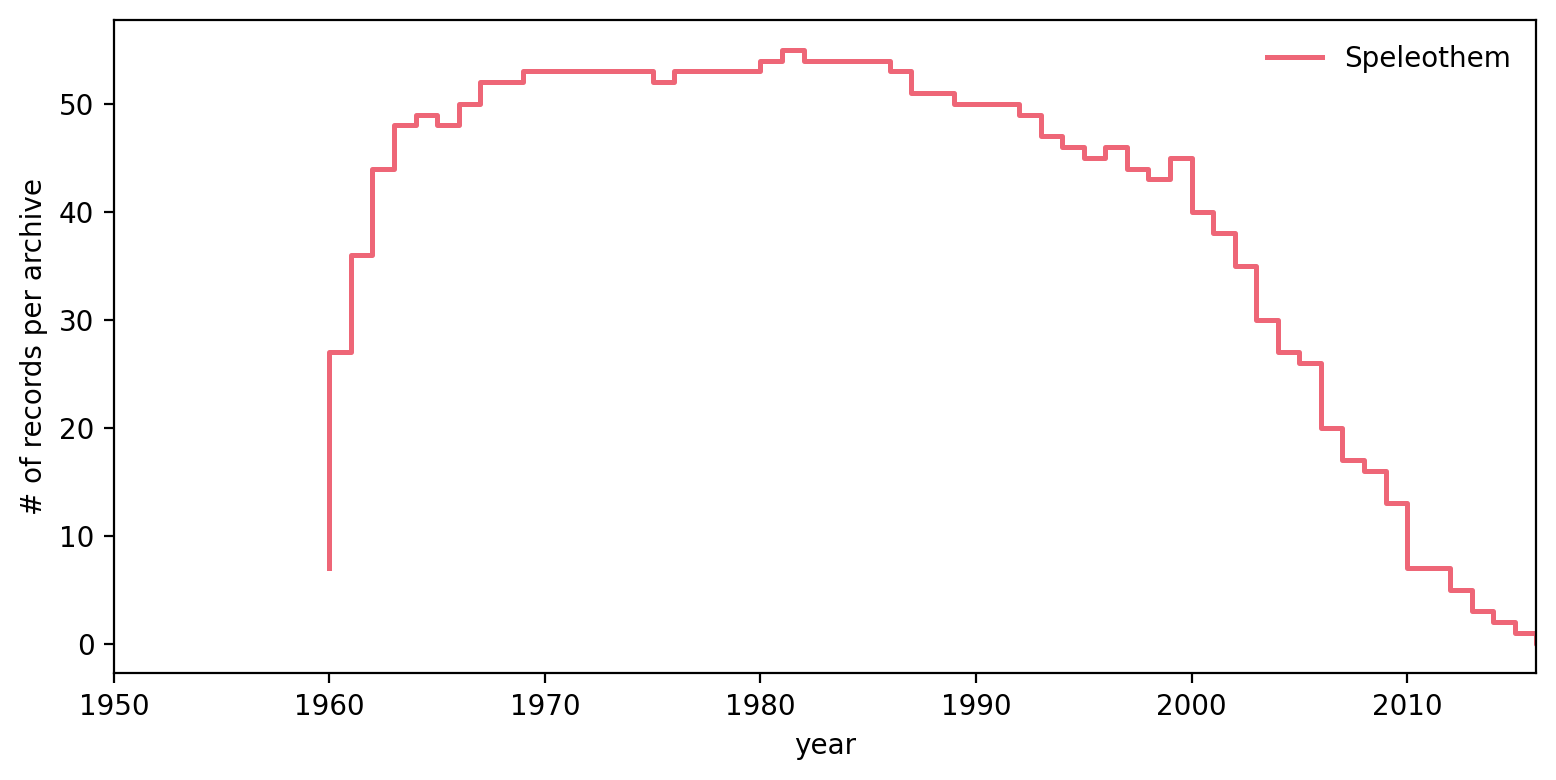

In [7]:
fig = uplt.plot_coverage(filtered_df, archives_sorted, ['Speleothem'], [], {'Speleothem':'#EE6677'})
plt.xlim(min_year-10, max_year+10)
utf.save_fig(fig, f'time_{filtered_df.name}', dir=filtered_df.name)

## save relevant data for speleothem analysis

In [8]:
# Choose relevant data for simulation comparison
df = filtered_df[['geo_meanLat', 'geo_meanLon', 'paleoData_values']]

# extract average of paleoData_values
df.loc[:,'paleoData_values'] = df.loc[:,'paleoData_values'].apply(np.average)

# create directory for speleo modeling inputs
os.makedirs('data/speleo_modeling', exist_ok=True)
df.to_csv('data/speleo_modeling/df_dod2k_speleo_analysis.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   geo_meanLat       61 non-null     float32
 1   geo_meanLon       61 non-null     float32
 2   paleoData_values  61 non-null     object 
dtypes: float32(2), object(1)
memory usage: 1.1+ KB


## load observations

### load CRU TS

In [ ]:
# Load temperature data, source: CRU TS 4.07 tmp
# wget https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.07/cruts.2304141047.v4.07/tmp/cru_ts4.07.1901.2022.tmp.dat.nc.gz
ds = xr.open_dataset('data/speleo_modeling/cru_ts4.07.1901.2022.tmp.dat.nc.gz')

'wget' is not recognized as an internal or external command,
operable program or batch file.


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\aegir\\Documents\\PaleoCoLab\\dod2k\\data\\speleo_modeling\\cru_ts4.07.1901.2022.tmp.dat.nc.gz'

In [ ]:
cruT_mon = ds['tmp']

In [ ]:
#Reduce this DataArray’s data by applying mean along some dimension(s).
cruT=cruT_mon.mean(dim='time')
print(cruT)

<xarray.DataArray 'tmp' (lat: 360, lon: 720)> Size: 1MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lon      (lon) float32 3kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 1kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75


### Load observed isotope data

In [ ]:
path = 'data/speleo_modeling/GlobalPrecip/d18o_MA.tif'
d18Op_da = rioxarray.open_rasterio(path)
if d18Op_da.sizes.get("band", 1) == 1:
    d18Op_da = d18Op_da.squeeze('band', drop=True)
d18Op_da = d18Op_da.rename({'x': 'lon', 'y': 'lat'})
d18Op_da = d18Op_da.where(np.abs(d18Op_da)<1e3)  # mask NaN regions
d18Op_da.attrs['units'] = 'permil'
d18Op_da.attrs['long_name'] = 'd18Op'
d18Op_da.name = 'd18Op'
#d18Op_da

### Join data

In [ ]:
# create a dataframe to hold observed o18, T,o18p, pred o18c
pred_frame = pd.DataFrame()
pred_frame['geo_meanLon'] = filtered_df['geo_meanLon']
pred_frame['geo_meanLat'] = filtered_df['geo_meanLat']
pred_frame['d18Oc_vals'] = filtered_df['paleoData_values']
pred_frame['d18Op_vals'] = object
pred_frame['cruT_vals'] = object
pred_frame['d18Ocs_vals']= object #np.zeros(len['d18Op_vals'])#object #np.nan # object # np.nan(len(['d18Op_vals']))
print(len(pred_frame['d18Ocs_vals']))

# KF: Finding nearest param data to observed data
for idx, row in tqdm(pred_frame.iterrows(), total=len(pred_frame)):
    lon = row['geo_meanLon']
    lat = row['geo_meanLat']

    # temp
    nearest_cruT = uta.find_nearest2d(cruT, lat, lon, lat_name='lat', lon_name='lon', new_dim='sites',r=6)
    if np.isnan(nearest_cruT).all():
        pred_frame.at[idx, 'cruT_vals'] = np.nan
    else:
        pred_frame.at[idx, 'cruT_vals'] = nearest_cruT.data
        #pred_frame.at[idx, 'cruT_vals'] = np.repeat(nearest_cruT.data,46)

    # d18Op
    nearest_o18p = uta.find_nearest2d(d18Op_da, lat, lon, lat_name='lat', lon_name='lon', new_dim='sites', r=6)
    if np.isnan(nearest_o18p).all():
        pred_frame.at[idx, 'd18Op_vals'] = np.nan
    else:
        pred_frame.at[idx, 'd18Op_vals'] = nearest_o18p.data
        pred_frame.at[idx, 'd18Op_vals'] = np.repeat(nearest_o18p.data,46)
        
#pred_frame
# KF: Important to note that the simulated records use data collected from sites closest to, but not always at the same location as, the observed records
# KF: This data collection is done above. Methods for finding the nearest gridpoint to an observation can be found in the functions.py file, function find_nearest2d, written by Feng Zhu

61


100%|██████████| 61/61 [00:00<00:00, 573.56it/s]


In [ ]:
# d18Oc averages 
d18Oc=[] # create an empty list
for idx in range(len(pred_frame)):
    #print(np.array(pred_frame['d18Oc_vals'][idx][0])) # this is what I want in my list.
    # populate the list
    d18Oc.append(pred_frame['d18Oc_vals'][idx][0])

d18Oc=pd.DataFrame(d18Oc).values # convert list to df
d18Oc=d18Oc.reshape(-1,1) # transpose list
#print(d18Oc)
# put these into the data frame in place of the raw values
pred_frame['d18Oc_vals'] = d18Oc

In [ ]:
# sanity check - nonmissing data found?
pred_frame.isna().sum()


geo_meanLon    0
geo_meanLat    0
d18Oc_vals     0
d18Op_vals     0
cruT_vals      0
d18Ocs_vals    0
dtype: int64

## Modeling

### Simulate Speleothem Data with PRYSM Model

PRYSM Speleothem Simulation Model Usage

Speleothem Calcite [Sensor] Model
  Converts environmental signals to d18O calcite/dripwater using
  various models of karst aquifer recharge and calcification.

  INPUTS:
      dt        time step [years]                         (int or float, 1=1 year, 1./12. for months. etc.)
      t        time axis [years]                          (numpy array, length n)
      T        Average Annual Temperature     [K]         (numpy array, length n)
      d18O    delta-18-O (precip or soil water) [permil]  (numpy array, length n)
      NB: make sure these are precipitation weighted

  MODEL PARAMETERS:
  
      model:  aquifer recharge model. possible values 'Well-Mixed'[1,2] or 'Adv-Disp' [3]
      tau0: mean transit time, [years]    (default = 0.5)
      Pe: Peclet number [non-dimensional] (default = 1.0) ('Adv-Disp' only)

   OUTPUTS:
       d18Oc  cave dripwater delta-18-O
       d18OK  delta-18-O of water after passage through karst
       h      transit time distribution

In [ ]:
# Simulation construction: using a series of 1960-2005 constant mean annual d18Op over time and a mean annual cruT to simulated d18Ocs
# because we use a constant o18p over time, the results are for equilibrium, well-mixed conditions over the time interval of study, 1960-2005
dt = 1
t = np.arange(min_year, max_year)
pred_frame['d18Ocs_vals'] = pred_frame.apply(lambda row: np.mean(psm.speleo.sensor.speleo_sensor(t,np.array(row['d18Op_vals']),np.array(row['cruT_vals']) + 273.15,dt,model='Well-Mixed',tau0=1)[0]),axis=1)
pred_frame

,geo_meanLon,geo_meanLat,d18Oc_vals,d18Op_vals,cruT_vals,d18Ocs_vals
0,-55.450001,-4.066700,-5.930000,"[-4.90709, -4.90709, -4.90709, -4.90709, -4.90...",26.539503,-7.223432
1,0.780000,45.430000,-4.559933,"[-6.67699, -6.67699, -6.67699, -6.67699, -6.67...",11.989003,-5.773501
2,105.116699,33.583302,-7.730000,"[-9.10825, -9.10825, -9.10825, -9.10825, -9.10...",10.181901,-7.772914
3,105.116699,33.583302,-8.874000,"[-9.10825, -9.10825, -9.10825, -9.10825, -9.10...",10.181901,-7.772914
4,15.000000,67.000000,-7.062788,"[-13.5065, -13.5065, -13.5065, -13.5065, -13.5...",1.8243847,-10.063785
...,...,...,...,...,...,...
56,-9.490000,30.770000,-4.571000,"[-5.79046, -5.79046, -5.79046, -5.79046, -5.79...",15.463603,-5.700161
57,115.690002,-31.547001,-3.180740,"[-4.11277, -4.11277, -4.11277, -4.11277, -4.11...",18.29258,-4.664288
58,7.664700,51.367500,-5.273960,"[-7.7014, -7.7014, -7.7014, -7.7014, -7.7014, ...",8.7618885,-6.016585
59,30.711700,37.232498,-3.770000,"[-7.73942, -7.73942, -7.73942, -7.73942, -7.73...",15.118716,-7.570000


In [ ]:
# get column vectors of data for regression estimation
# 1. d18Ocs
d18Ocs=pred_frame.iloc[:,5].values
d18Ocs=d18Ocs.reshape(-1,1)
#print(d18Ocs)

In [ ]:
# 2. d18Op 
d18Op=[] # create an empty list
for idx in range(len(pred_frame)):
    #print(np.array(pred_frame['d18Op_vals'][idx][0])) # this is what I want in my list.
    # populate the list
    d18Op.append(pred_frame['d18Op_vals'][idx][0])

d18Op=pd.DataFrame(d18Op).values # convert list to df
d18Op=d18Op.reshape(-1,1) # transpose list
#print(d18Op)

In [ ]:
# 3. d18Oc
# is already created
#print(d18Oc)

In [ ]:
# 4. Temp
Temp=pred_frame.iloc[:,4].values
Temp=Temp.reshape(-1,1)
#print(Temp)

## Regression Comparisons

### Regress and plot

#### regression of o18p on o18c

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     76.03
Date:                Sat, 20 Dec 2025   Prob (F-statistic):           3.36e-12
Time:                        11:22:19   Log-Likelihood:                -111.82
No. Observations:                  61   AIC:                             227.6
Df Residuals:                      59   BIC:                             231.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6536      0.417     -6.358      0.0

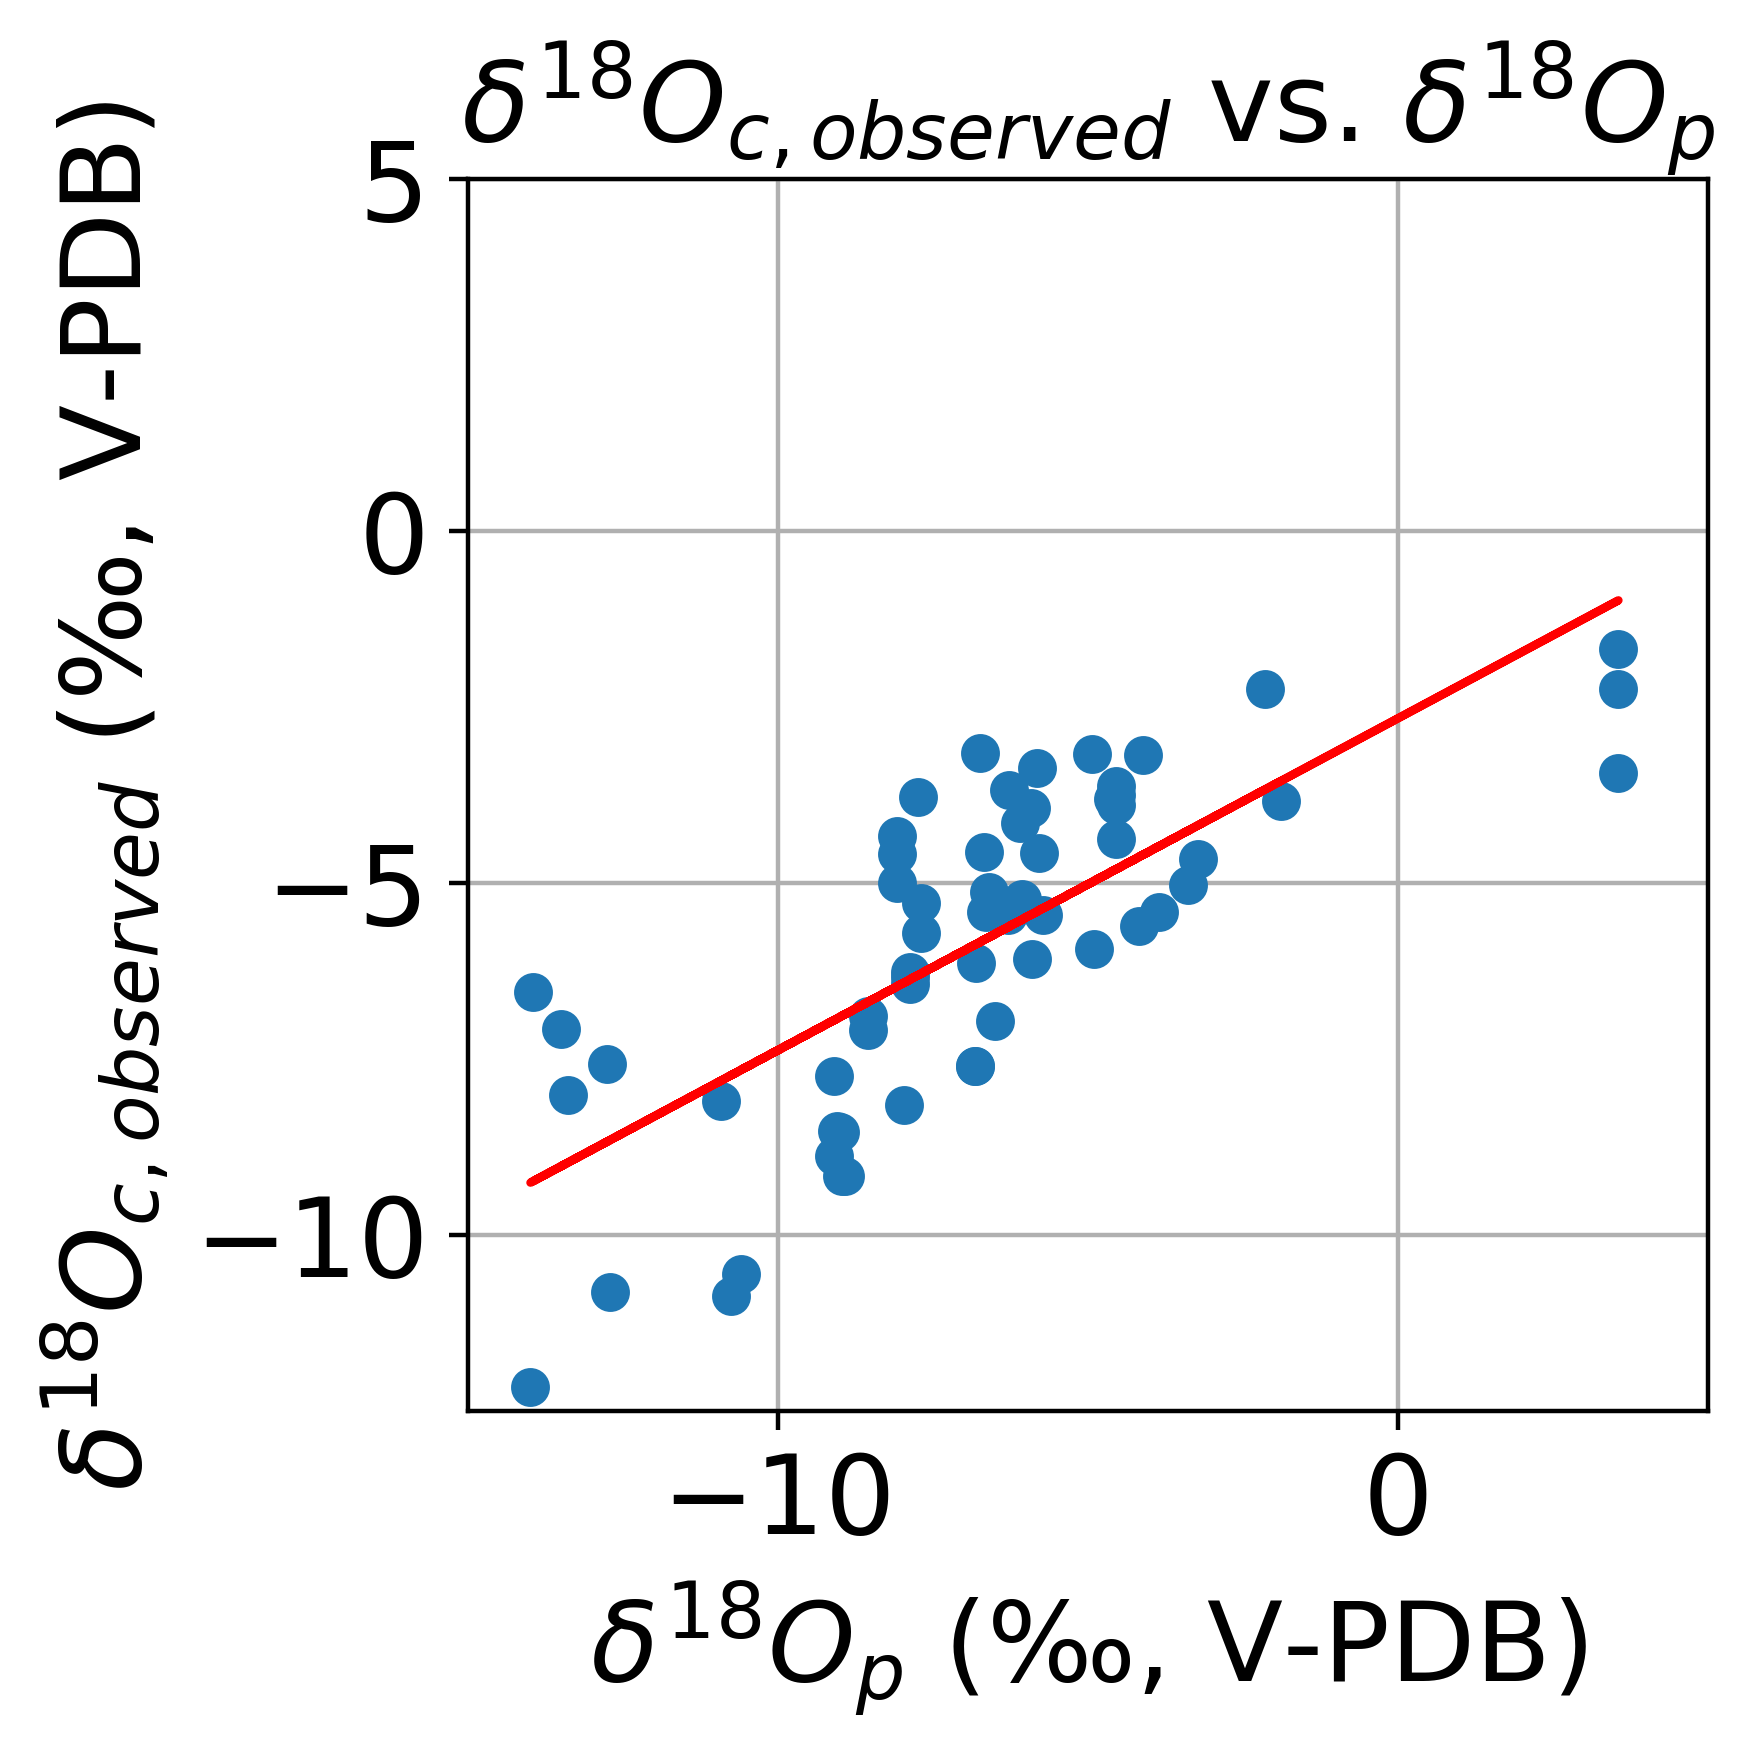

In [ ]:
# 1. get regression of o18p on o18c
# Using statsmodels OLS, see: https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html
d18OpI = sm.add_constant(d18Op)
model1 = sm.OLS(d18Oc, d18OpI)
res1 = model1.fit()
print(res1.summary())

plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(4,4), dpi=400)
#plt.plot(d18Op,d18Oc,'o',d18Op,d18Ochat,'r-')
plt.plot(d18Op,d18Oc,'o', d18Op, res1.predict(d18OpI), 'r-')

plt.xlabel(r"$\delta^{18}O_{p}$ (" f"\u2030, V-PDB)", fontsize=20) # MNE cleaned up the plot labeling
plt.ylabel(r"$\delta^{18}O_{c,observed}$ (" f"\u2030, V-PDB)", fontsize=20)
plt.xlim([-15, 5])
plt.ylim([-12.5, 5])
plt.title(r"$\delta^{18}O_{c,observed}$ vs. $\delta^{18}O_{p}$", fontsize=20)

plt.grid(True)
plt.show
utf.save_fig(fig, f'o18c_on_o18p_{filtered_df.name}', dir=filtered_df.name)

#### regression of o18c on T

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     7.259
Date:                Sat, 20 Dec 2025   Prob (F-statistic):            0.00917
Time:                        11:22:20   Log-Likelihood:                -133.54
No. Observations:                  61   AIC:                             271.1
Df Residuals:                      59   BIC:                             275.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.4639      0.658    -11.348      0.0

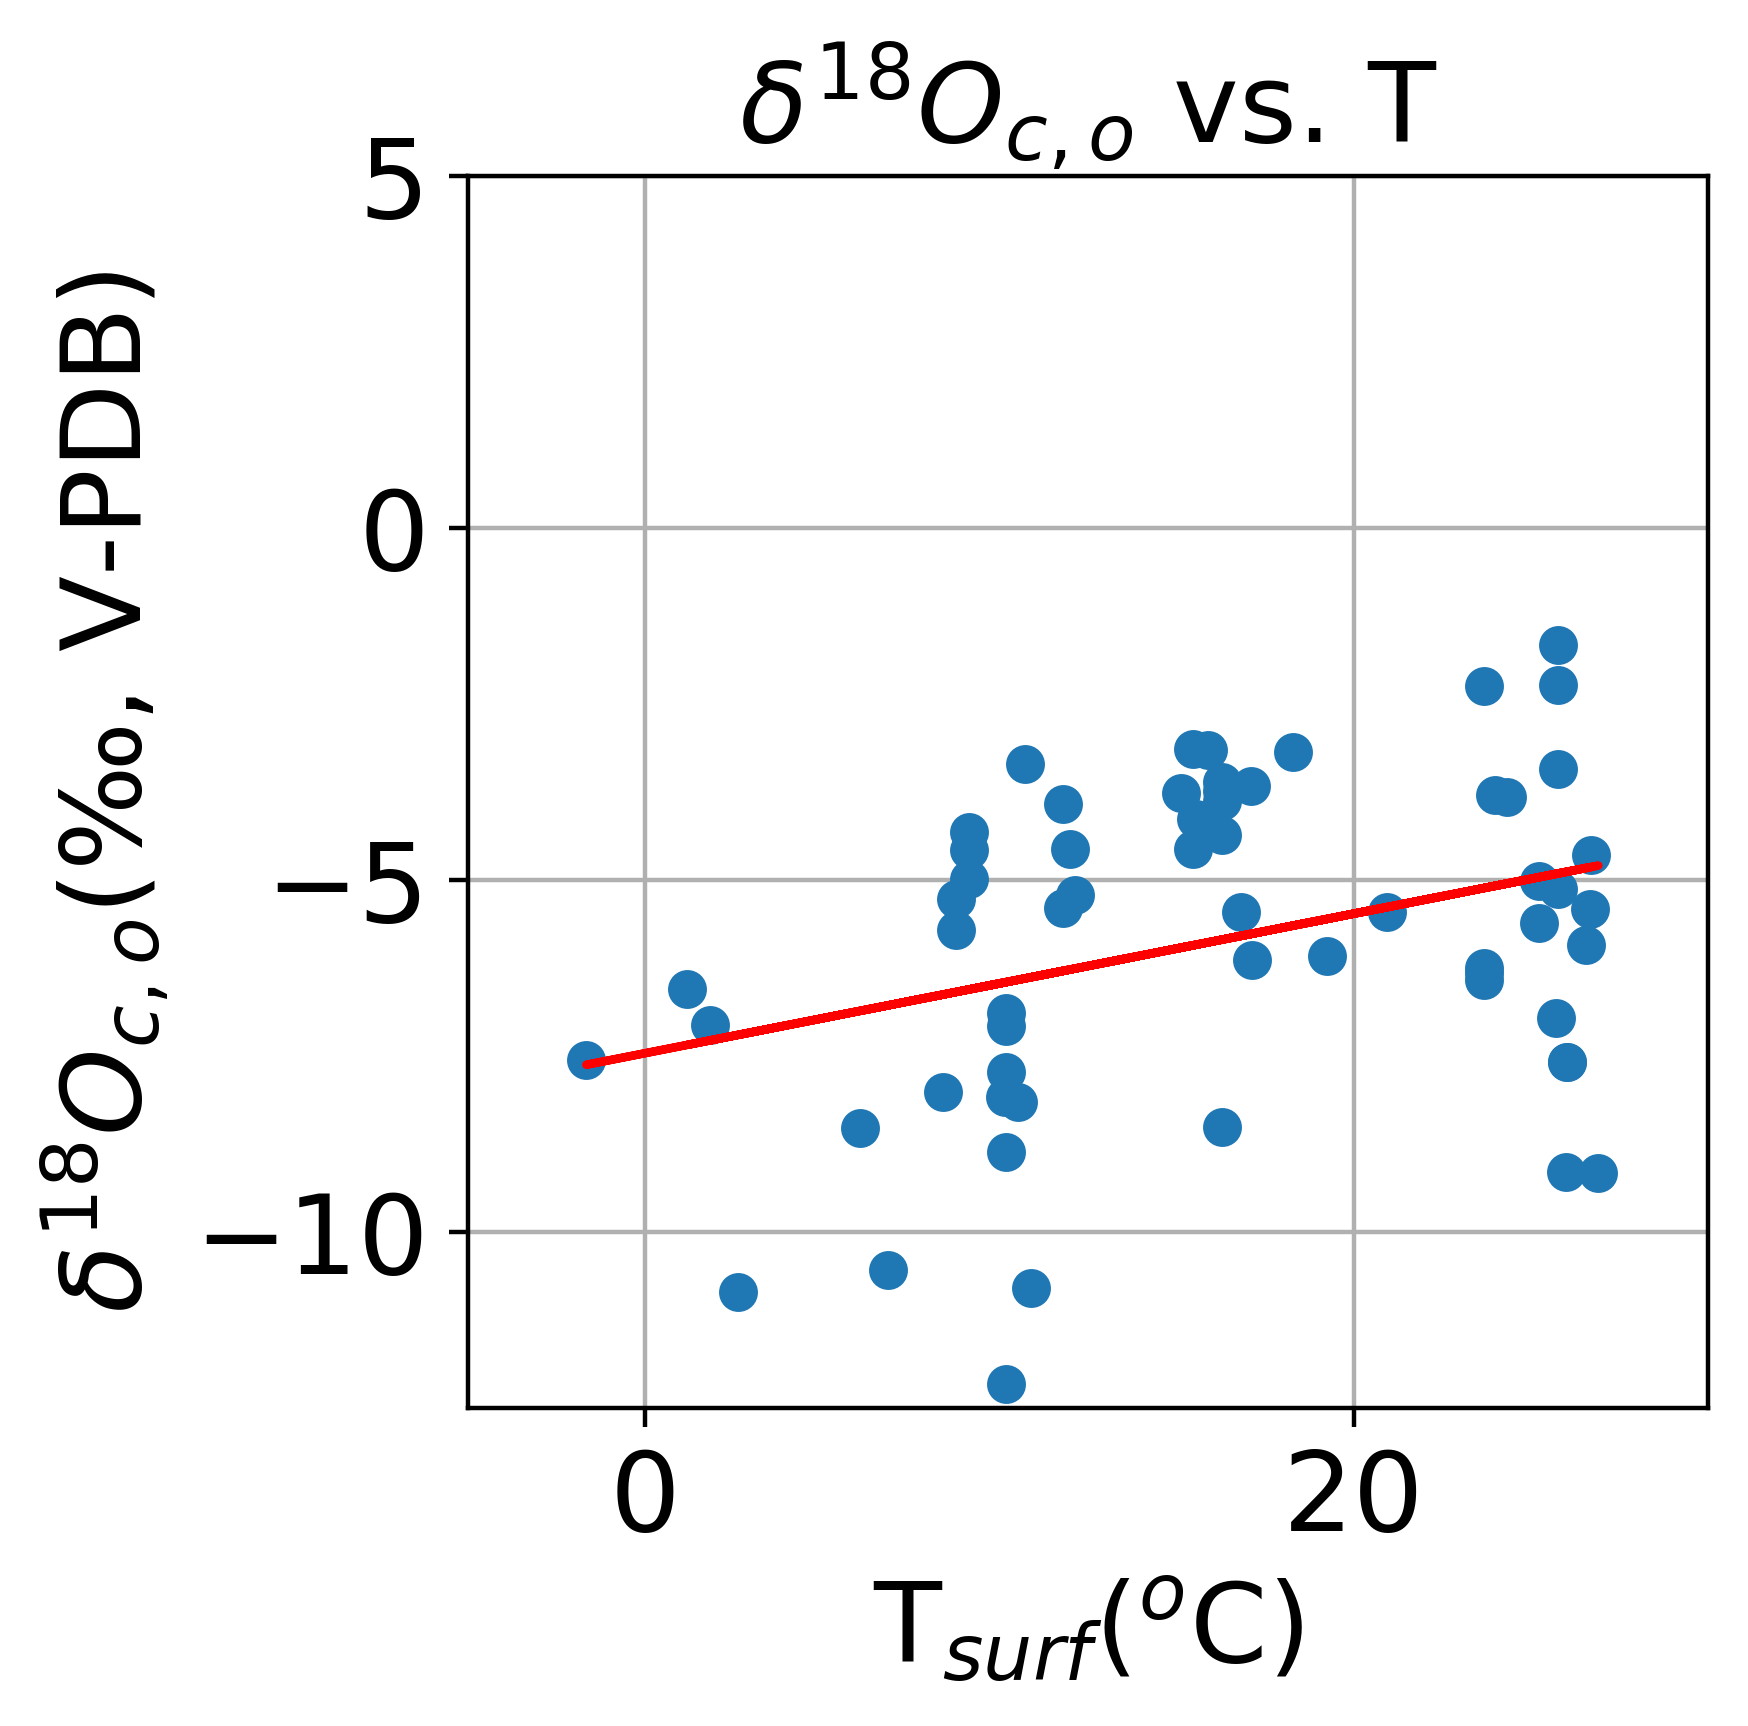

In [ ]:
# 2. get regression of o18c on T

TempL = sm.add_constant(np.array(list(map(lambda x: x[0], Temp))))
model2 = sm.OLS(d18Oc, TempL)
res2 = model2.fit()
print(res2.summary())

plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(4,4), dpi=400)
plt.plot(Temp, d18Oc,'o', Temp, res2.predict(TempL), 'r-')

plt.ylabel(r"$\delta^{18}O_{c,o}$" f"(\u2030, V-PDB)",fontsize=20) # MNE cleaned up the plot labeling
plt.xlabel(r"T$_{surf}$($^{o}$C)", fontsize=20)
plt.title(r"$\delta^{18}O_{c,o}$ vs. T", fontsize=20)
plt.ylim([-12.5, 5])
plt.xlim([-5, 30])
plt.show
plt.grid(True)
utf.save_fig(fig, f'o18c_on_T_{filtered_df.name}', dir=filtered_df.name)

#### regression of o18cs on o18c 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     84.17
Date:                Sat, 20 Dec 2025   Prob (F-statistic):           5.86e-13
Time:                        11:22:21   Log-Likelihood:                -121.95
No. Observations:                  61   AIC:                             247.9
Df Residuals:                      59   BIC:                             252.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3469      0.639     -2.107      0.0

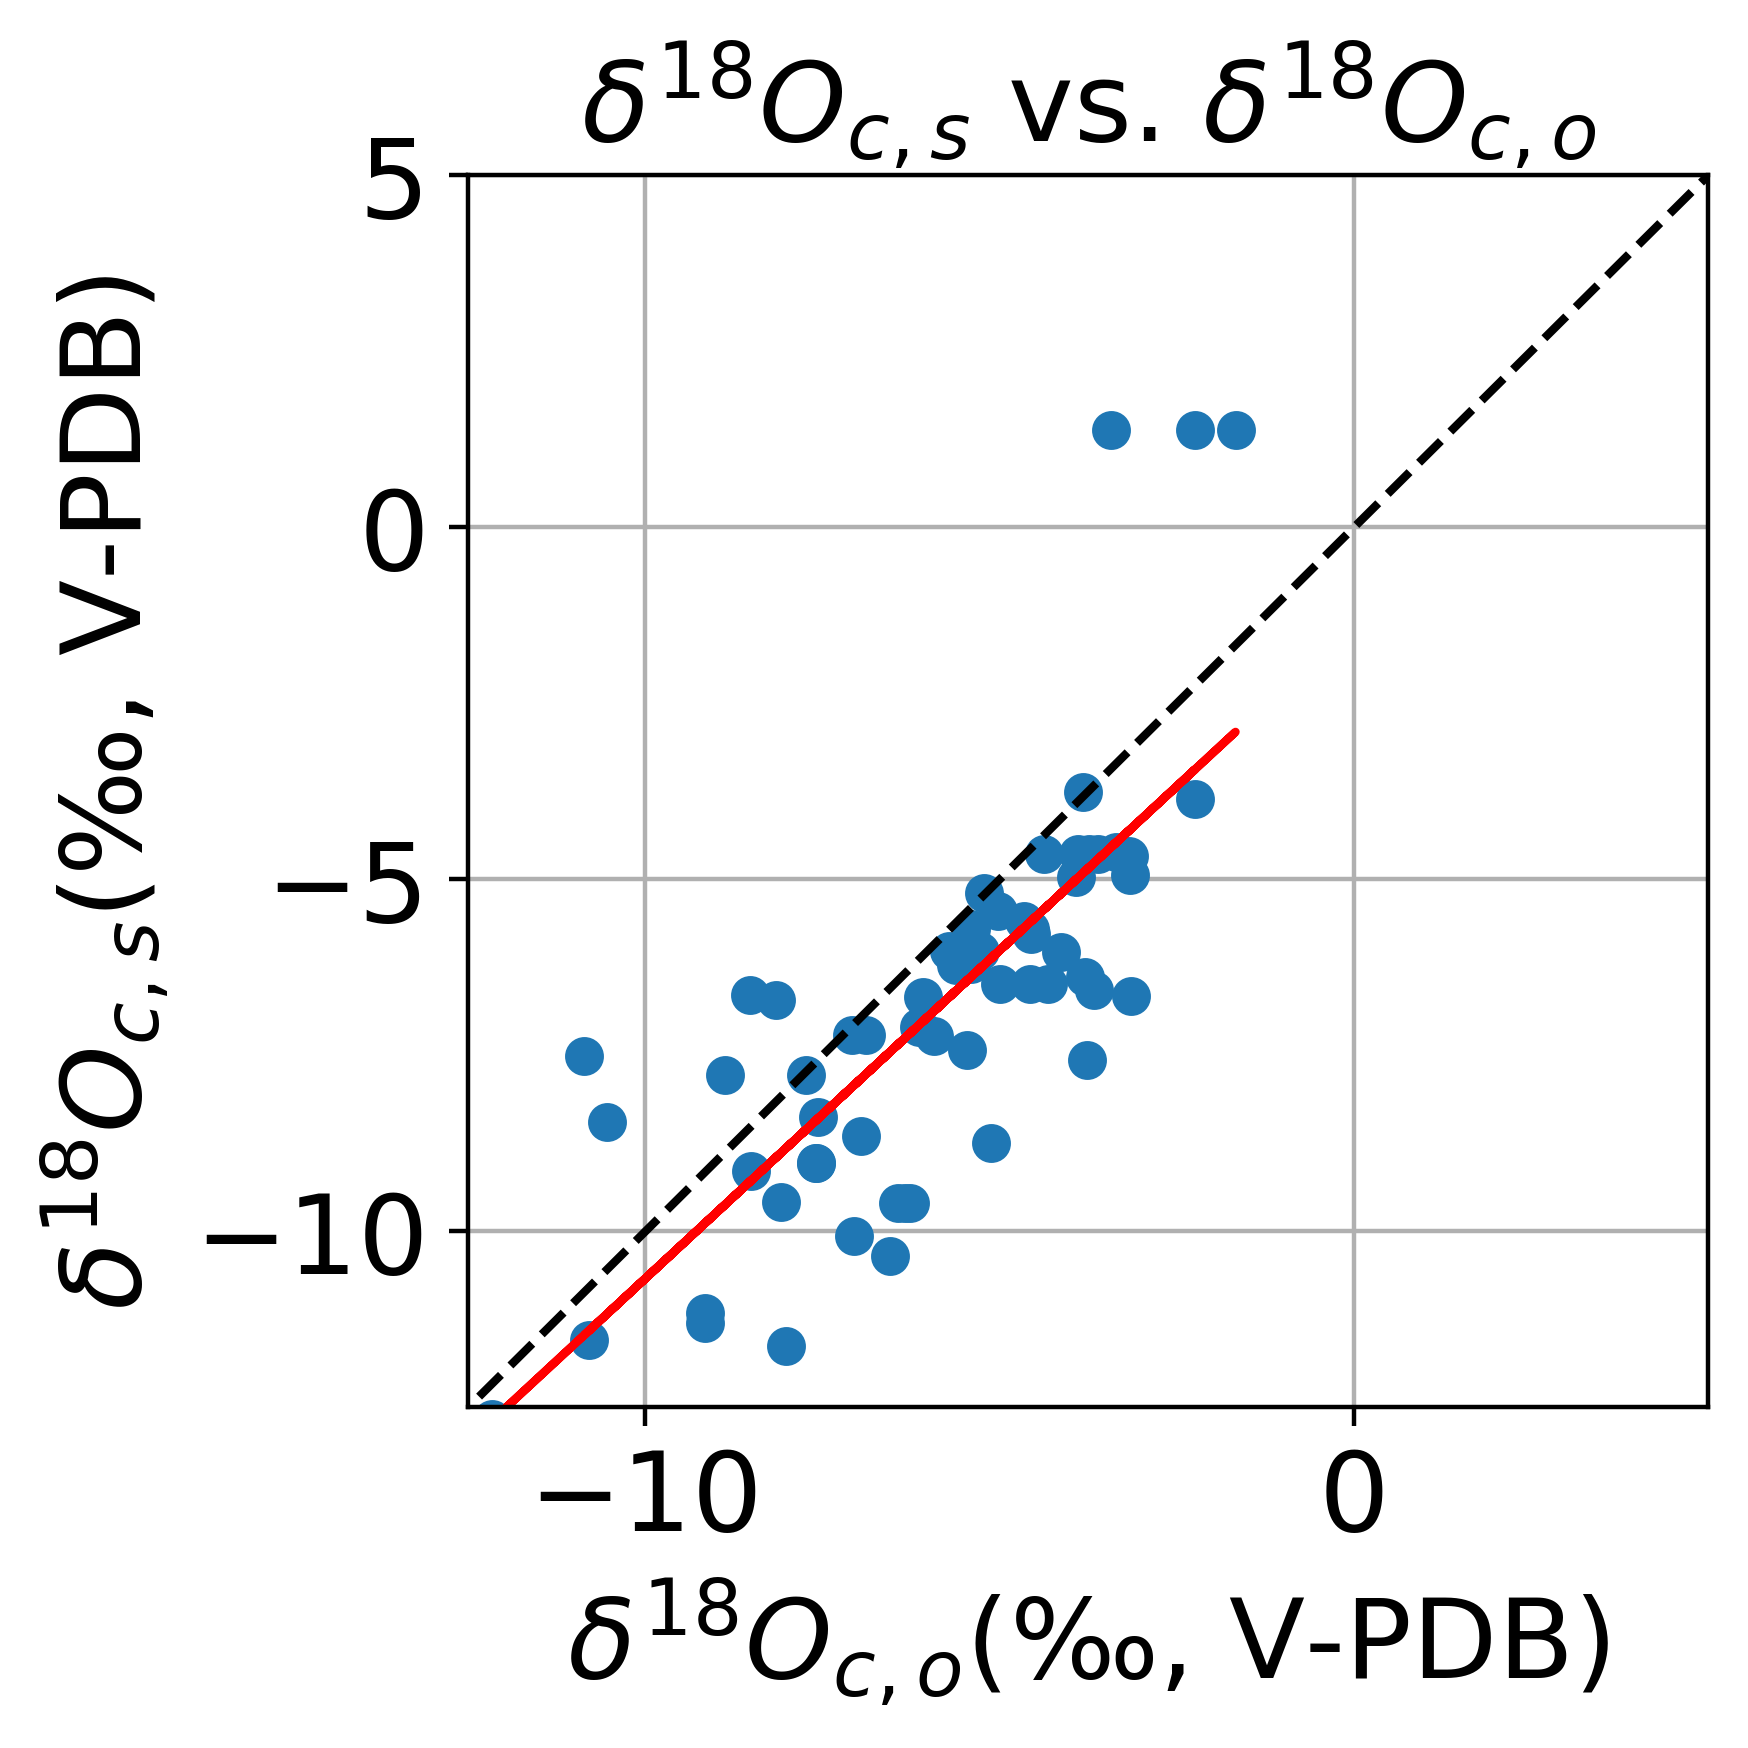

In [ ]:
# 3. get regression of o18cs on o18c 
cL = np.array(list(map(lambda x: x[0], d18Oc)))
d18OcI = sm.add_constant(d18Oc)
model3 = sm.OLS(d18Ocs, d18OcI)
res3 = model3.fit()
d18Ocshat = res3.predict(d18OcI)
print(res3.summary())

#Plot line of slope 1 with same intercept for comparison
plt.rcParams.update({'font.size': 20})
d18Ocs_line = np.linspace(-15,5,100) # MNE adjusted 1:1 line range
d18Oc_line = d18Ocs_line 
fig = plt.figure(figsize=(4,4), dpi=400)
plt.plot(d18Oc,d18Ocs,'o', cL, d18Ocshat,'r-',d18Oc_line,d18Oc_line,'k--')

plt.xlabel(r"$\delta^{18}O_{c,o}$" f"(\u2030, V-PDB)", fontsize=20) # MNE cleaned up the plot labeling
plt.ylabel(r"$\delta^{18}O_{c,s}$" f"(\u2030, V-PDB)", fontsize=20)
plt.title(r"$\delta^{18}O_{c,s}$ vs. $\delta^{18}O_{c,o}$", fontsize=20)

plt.xlim([-12.5, 5])
plt.ylim([-12.5, 5])
plt.show
plt.grid(True)
utf.save_fig(fig, f'o18cs_on_o18c_{filtered_df.name}', dir=filtered_df.name)

## Measures of Regression

In [ ]:
# are the 1:1 and o18cs on d18Oc slopes significantly different?
print('slope of regression of o18cs vs o18co: ', np.round(res3.params[1],2))
print('standard error of regression of o18cs vs o18co: ', np.round(res3.bse[1],2))
#t_slope_1=res3.tvalues[1]
t_slope_1=(res3.params[1]-1)/res3.bse[1]
print('t value for slope of o18cs vs o18co vs 1:1 slope: ', np.round(t_slope_1,2))
p_value_slope=[2*(scipy.stats.t.cdf(t_slope_1,(len(d18Oc)-2)))]
print('p value: ', np.round(p_value_slope,8))
mean_diff=(np.mean(d18Ocs)-np.mean(d18Oc))
print('mean difference (d18Oc - d18Ocs): ', np.round(mean_diff,2))
se_mean_diff=np.sqrt(np.mean(np.std(d18Ocs)**2/len(d18Ocs)+np.std(d18Oc)**2/len(d18Oc)))
print('standard error of the mean difference: ', np.round(se_mean_diff,2))
t_mean_diff=(np.mean(d18Oc)-np.mean(d18Ocs))/np.sqrt(np.mean(np.std(d18Ocs)**2/len(d18Ocs)+np.std(d18Oc)**2/len(d18Oc)))
print('t_mean_diff: ', np.round(t_mean_diff,2))
p_value_mean_diff=[2*(1-scipy.stats.t.cdf(t_mean_diff,(len(d18Oc)-2)))]
print('p value for difference of means: ', np.round(p_value_mean_diff,4))
# simulated d18Oc is significantly lower than observed d18Oc
# this difference is about 
frac_diff=np.abs(mean_diff)/(np.max(d18Oc)-np.min(d18Oc))
print('percent bias: {}%'.format(np.round(frac_diff*100,1)))

slope of regression of o18cs vs o18co:  0.93
standard error of regression of o18cs vs o18co:  0.1
t value for slope of o18cs vs o18co vs 1:1 slope:  -0.67
p value:  [0.5068511]
mean difference (d18Oc - d18Ocs):  -0.95
standard error of the mean difference:  0.46
t_mean_diff:  2.06
p value for difference of means:  [0.0441]
percent bias: 9.0%


In [ ]:
# clean up the dataframe to list only the mean value of o18p in the corresponding column of the data 
pred_frame['d18Op_vals']=d18Op
pd.set_option('display.max_rows', None)
pred_frame

,geo_meanLon,geo_meanLat,d18Oc_vals,d18Op_vals,cruT_vals,d18Ocs_vals
0,-55.450001,-4.066700,-5.930000,-4.90709,26.539503,-7.223432
1,0.780000,45.430000,-4.559933,-6.67699,11.989003,-5.773501
2,105.116699,33.583302,-7.730000,-9.10825,10.181901,-7.772914
3,105.116699,33.583302,-8.874000,-9.10825,10.181901,-7.772914
4,15.000000,67.000000,-7.062788,-13.50650,1.8243847,-10.063785
5,-115.580002,37.889999,-10.800750,-12.70770,10.885996,-11.546725
6,14.000000,66.000000,-6.545692,-13.95680,1.1765707,-10.343617
7,167.016693,-15.533300,-5.610000,-4.17462,25.233316,-6.222805
8,-89.716003,20.730000,-4.652315,-3.23295,26.692095,-5.584510
9,91.866699,25.250000,-5.456000,-6.29485,20.941175,-7.427842


## Bibliography
Bowen, G.J., Wassenaar, L.I., Hobson, K.A. (2005). Global application of stable hydrogen and oxygen isotopes to wildlife forensics. Oecologia 143, 337–348. https://doi.org/10.1007/s00442-004-1813-y.  Data retrieved from:  https://wateriso.utah.edu/waterisotopes/media/ArcGrids/GlobalPrecip.zip, last accessed 2025/08/03.  <br> <br>
Dee, S., J. Emile-Geay, M. N. Evans, A. Allam, E. J. Steig, and D. M. Thompson (2015). PRYSM: An open-source framework for PRoxY System Modeling, with applications to oxygen-isotope systems. J. Adv. Model. Earth Syst., 7, 1220–1247. https://doi.org/10.1002/2015MS000447. <br> <br>
Harris, I., Osborn, T.J., Jones, P. et al. (2020). Version 4 of the CRU TS monthly high-resolution gridded multivariate climate dataset. Sci Data 7, 109. https://doi.org/10.1038/s41597-020-0453-3.  Data retrieved from:  https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.07/cruts.2304141047.v4.07/tmp/cru_ts4.07.1901.2022.tmp.dat.nc.gz, last accessed 2025/08/03. <br> <br>
Hu, J., J. Emile-Geay, J. Partin (2017). Correlation-based interpretations of paleoclimate data – where statistics meet past climates, Earth and Planetary Science Letters, 459, 362-371. https://doi.org/10.1016/j.epsl.2016.11.048.